In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def square_pad(image):
    h_diff = max(image.shape) - image.shape[0]
    w_diff = max(image.shape) - image.shape[1]

    top = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    bottom = h_diff // 2
    left = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2    
    right = w_diff // 2
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_image, image.shape

def remove_padding(padded_image, original_shape):
    h_diff = padded_image.shape[0] - original_shape[0]
    w_diff = padded_image.shape[1] - original_shape[1]

    h_start = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    h_end = padded_image.shape[0] - h_diff // 2
    w_start = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2
    w_end = padded_image.shape[1] - w_diff // 2

    return padded_image[h_start:h_end, w_start:w_end]

c:\Users\Alqia\miniconda3\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


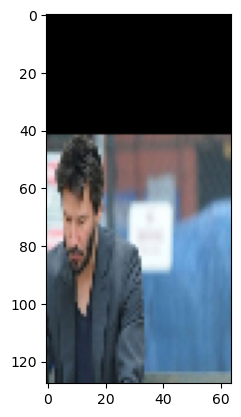

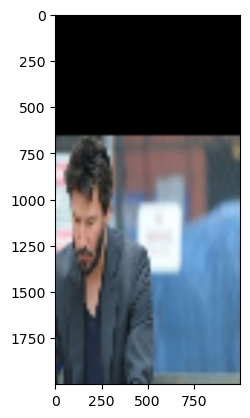

In [41]:
image = cv2.imread('out_of_distribution_images/SadKeanu.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image, image_shape = square_pad(image)
image = transforms.ToTensor()(image)
image = transforms.RandomResizedCrop((128,64))(image)
#image = remove_padding(image, image_shape)
plt.figure()
plt.imshow(image.permute(1, 2, 0))
image = transforms.Resize(1000)(image)
plt.figure()
plt.imshow(image.permute(1, 2, 0))

In [42]:
mat = np.random.randint(0,5, (3,4,4), dtype=np.uint8)
print(mat)
import torch
mat = torch.from_numpy(mat)
print(mat.view(3,-1))
num = torch.ones(4,4)
num = num.view(-1)
print(num)

[[[4 4 2 0]
  [0 3 4 0]
  [3 4 2 2]
  [2 2 3 3]]

 [[3 3 4 3]
  [1 3 4 0]
  [3 2 1 1]
  [4 1 1 1]]

 [[2 4 0 3]
  [4 3 1 1]
  [0 4 1 2]
  [0 0 2 0]]]
tensor([[4, 4, 2, 0, 0, 3, 4, 0, 3, 4, 2, 2, 2, 2, 3, 3],
        [3, 3, 4, 3, 1, 3, 4, 0, 3, 2, 1, 1, 4, 1, 1, 1],
        [2, 4, 0, 3, 4, 3, 1, 1, 0, 4, 1, 2, 0, 0, 2, 0]], dtype=torch.uint8)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [43]:
image = cv2.imread('archive/PNGImages/FudanPed00019.png')
mask = cv2.imread('archive/PedMasks/FudanPed00019_mask.png', 0)
print(image.shape, mask.shape)
merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
print(merged_image.shape)
merged_image, image_shape = square_pad(merged_image)
print(merged_image.shape)
#merged_image = remove_padding(merged_image, image.shape)
#print(merged_image.shape)
merged_image = transforms.ToTensor()(merged_image)
# separate image and mask as different tensors of [3, 256, 256] and [1, 256, 256]
image = merged_image[:3, :, :]
mask = merged_image[3, :, :].unsqueeze(0)
print(image.shape, mask.shape)
# however the mask is [256, 256] and we need to convert it to [1, 256, 256]
mask = mask.unsqueeze(0)
print(mask.shape)


(442, 497, 3) (442, 497)
(442, 497, 4)
(497, 497, 4)
torch.Size([3, 497, 497]) torch.Size([1, 497, 497])
torch.Size([1, 1, 497, 497])


In [44]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn

def square_pad(image):
    h_diff = max(image.shape) - image.shape[0]
    w_diff = max(image.shape) - image.shape[1]

    top = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    bottom = h_diff // 2
    left = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2    
    right = w_diff // 2
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_image, image.shape

def remove_pad(padded_image, original_shape):
    h_diff = padded_image.shape[0] - original_shape[0]
    w_diff = padded_image.shape[1] - original_shape[1]

    h_start = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    h_end = padded_image.shape[0] - h_diff // 2
    w_start = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2
    w_end = padded_image.shape[1] - w_diff // 2

    return padded_image[h_start:h_end, w_start:w_end]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=None, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        if self.transform or self.image_size:
            merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
            merged_image, merged_shape = square_pad(merged_image)
            merged_image = transforms.ToTensor()(merged_image)
            if self.transform:
                merged_image = self.transform(merged_image)
            if self.image_size:
                merged_image = transforms.Resize((self.image_size, self.image_size))(merged_image)
            image = merged_image[:3, :, :]
            mask = merged_image[3, :, :].unsqueeze(0)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        return image, mask, merged_shape
    
dataset = PennFudanDataset(["archive/PNGImages/FudanPed00002.png"], ["archive/PedMasks/FudanPed00002_mask.png"], image_size=256)
    
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for image, mask, shape in dataloader:
    print(image.shape, mask.shape, shape)
    break

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) [tensor([414]), tensor([455]), tensor([4])]


In [54]:
# make a tensor that is (8, 1, 64, 64) with ascending values
tensor = torch.arange(0, 4*4).view(1, 4, 4).repeat(4, 1, 1).float()
print(tensor.shape)
tensor = tensor.view(-1)
print(tensor)

def dice_coefficient(output, ground_truth):
    numerical_stability = 1.
    output = output.view(-1)
    ground_truth = ground_truth.view(-1)
    intersection = (output * ground_truth).sum()
    return (2. * intersection + numerical_stability) / (output.sum() + ground_truth.sum() + numerical_stability)

def forward(output, ground_truth):
    return 1 - dice_coefficient(output, ground_truth)

torch.Size([4, 4, 4])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
        10., 11., 12., 13., 14., 15.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
         8.,  9., 10., 11., 12., 13., 14., 15.])


In [55]:
print((tensor*tensor).sum())
print(tensor.sum()*2)
print(2*((tensor*tensor).sum()+1)/(tensor.sum()*2+1))
print(dice_coefficient(tensor, tensor))
print(forward(tensor, tensor))

tensor(4960.)
tensor(960.)
tensor(10.3247)
tensor(10.3236)
tensor(-9.3236)
